In [1]:
import tensorflow as tf
from tensorflow import keras

(xtrain, ytrain), (xtest, ytest) = keras.datasets.reuters.load_data()
                                                                    
display(xtrain)

array([list([1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 30625, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4

In [2]:
word_index = keras.datasets.reuters.get_word_index()

In [3]:
index_to_word = dict()

for key, val in word_index.items():
    index_to_word[val] = key
    
voca_size = len(index_to_word)    

print(f'Vocabulary size is {voca_size}')    

Vocabulary size is 30979


In [4]:
# word index from dataset has 3 reserved words, thus minus 3
# see: https://technotes.webriki.com/2019/06/reserved-indices-in-keras-reuters-data.html

def get_word(idx):
    return index_to_word.get(idx-3, '?')

In [5]:
example_text = []

for N in range(5):
    for word_idx in xtest[N]:
        example_text.append(get_word(word_idx))
    
    sentence = ' '.join(example_text)
    print(f'{N}: {sentence}\n')

0: ? the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3

1: ? the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two ye

In [6]:
def build_cbow_tuples(train_data, ctx_size):
    cbow = []
    
    for paragraph in train_data:
        for i in range(ctx_size, len(paragraph) - ctx_size):
            cbow.append((
                paragraph[i-ctx_size:i] + paragraph[i+1:i+ctx_size+1], 
                paragraph[i],
            ))
            
    return cbow

In [7]:
CONTEXT_SIZE = 2
CONTEXT_WINDOW = CONTEXT_SIZE * 2

cbow_data = build_cbow_tuples(xtrain, CONTEXT_SIZE)

for i in range(20):
    print(cbow_data[i])
    print([get_word(w) for w in cbow_data[i][0]], get_word(cbow_data[i][1]))

([1, 27595, 8, 43], 28842)
['?', 'mcgrath', 'said', 'as'] rentcorp
([27595, 28842, 43, 10], 8)
['mcgrath', 'rentcorp', 'as', 'a'] said
([28842, 8, 10, 447], 43)
['rentcorp', 'said', 'a', 'result'] as
([8, 43, 447, 5], 10)
['said', 'as', 'result', 'of'] a
([43, 10, 5, 25], 447)
['as', 'a', 'of', 'its'] result
([10, 447, 25, 207], 5)
['a', 'result', 'its', 'december'] of
([447, 5, 207, 270], 25)
['result', 'of', 'december', 'acquisition'] its
([5, 25, 270, 5], 207)
['of', 'its', 'acquisition', 'of'] december
([25, 207, 5, 3095], 270)
['its', 'december', 'of', 'space'] acquisition
([207, 270, 3095, 111], 5)
['december', 'acquisition', 'space', 'co'] of
([270, 5, 111, 16], 3095)
['acquisition', 'of', 'co', 'it'] space
([5, 3095, 16, 369], 111)
['of', 'space', 'it', 'expects'] co
([3095, 111, 369, 186], 16)
['space', 'co', 'expects', 'earnings'] it
([111, 16, 186, 90], 369)
['co', 'it', 'earnings', 'per'] expects
([16, 369, 90, 67], 186)
['it', 'expects', 'per', 'share'] earnings
([369, 186

In [8]:
import numpy as np

def build_training_data():
    X = []
    y = []
    
    for tuple in cbow_data:
        context = tuple[0]
        label = tuple[1]
        
        ctx_size = len(context)
        xi = np.array(context)

        yi = np.zeros((voca_size,))
        if label >= voca_size:
            label = 2
        yi[label] = 1
        
        yield xi, yi

In [9]:
gen = build_training_data()

for i in range(10):
    xi, yi = next(gen)
    
    print(xi.shape, yi.shape)

(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)
(4,) (30979,)


In [10]:
# gen = build_training_data(cbow_data, voca_size)

train_data = tf.data.Dataset.from_generator(
    build_training_data,
    output_signature=(
        tf.TensorSpec(shape=(CONTEXT_WINDOW,), dtype=tf.int32),
        tf.TensorSpec(shape=(voca_size,), dtype=tf.int32),
    ),
).batch(16)

In [11]:
x1 = train_data.take(1)
display(train_data)
display(list(x1)[0])


<BatchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.int32, name=None), TensorSpec(shape=(None, 30979), dtype=tf.int32, name=None))>

(<tf.Tensor: shape=(16, 4), dtype=int32, numpy=
 array([[    1, 27595,     8,    43],
        [27595, 28842,    43,    10],
        [28842,     8,    10,   447],
        [    8,    43,   447,     5],
        [   43,    10,     5,    25],
        [   10,   447,    25,   207],
        [  447,     5,   207,   270],
        [    5,    25,   270,     5],
        [   25,   207,     5,  3095],
        [  207,   270,  3095,   111],
        [  270,     5,   111,    16],
        [    5,  3095,    16,   369],
        [ 3095,   111,   369,   186],
        [  111,    16,   186,    90],
        [   16,   369,    90,    67],
        [  369,   186,    67,     7]], dtype=int32)>,
 <tf.Tensor: shape=(16, 30979), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)

In [16]:
import tensorflow as tf
from tensorflow import keras

EMBEDDING_SIZE = 16

def build_cbow_model(ctx_window, voca_size, embed_dim):
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=(ctx_window,)))
    model.add(keras.layers.Embedding(voca_size, embed_dim, input_length=ctx_window))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(voca_size, activation='softmax'))
    
    model.compile(
        loss=tf.losses.CategoricalCrossentropy(),
        optimizer=tf.optimizers.Adam(learning_rate=1e-4),
        metrics=['acc'],
    )
    
    return model

model = build_cbow_model(CONTEXT_WINDOW, voca_size, 16)
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4, 16)             495664    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 30979)             526643    
                                                                 
Total params: 1,022,307
Trainable params: 1,022,307
Non-trainable params: 0
_________________________________________________________________


In [17]:
with tf.device('/GPU:0'):
    history = model.fit(train_data, epochs=30)

Epoch 1/30
79457/79457 [==============================] - 1171s 15ms/step - loss: 7.4938 - acc: 0.0509
Epoch 2/30
79457/79457 [==============================] - 1195s 15ms/step - loss: 6.8363 - acc: 0.0752
Epoch 3/30
79457/79457 [==============================] - 1190s 15ms/step - loss: 6.5939 - acc: 0.1043
Epoch 4/30
79457/79457 [==============================] - 1197s 15ms/step - loss: 6.4612 - acc: 0.1207
Epoch 5/30
79457/79457 [==============================] - 1190s 15ms/step - loss: 6.3717 - acc: 0.1330
Epoch 6/30
79457/79457 [==============================] - 1194s 15ms/step - loss: 6.3064 - acc: 0.1432
Epoch 7/30
79457/79457 [==============================] - 1191s 15ms/step - loss: 6.2590 - acc: 0.1514
Epoch 8/30
79457/79457 [==============================] - 1194s 15ms/step - loss: 6.2199 - acc: 0.1575
Epoch 9/30
79457/79457 [==============================] - 1193s 15ms/step - loss: 6.1865 - acc: 0.1621
Epoch 10/30
79457/79457 [==============================] - 1186s 15ms/ste

In [18]:
model.save('reuters-embedding')

INFO:tensorflow:Assets written to: reuters-embedding/assets


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8rjfcm6x because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


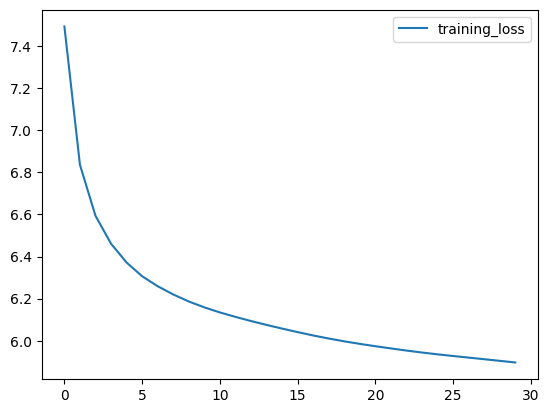

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training_loss')
plt.legend()
plt.show()